# 폐렴 진단하기
---
## Step1. 실험환경 Set-up
---
#### 라이브러리

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

#### 변수 선언

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


---
## 데이터 준비하기
---

### 데이터 셋
#### 캐글의 Chest X-Ray Images  
해당 이미지는 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5 세 소아 환자의 흉부 X선 영상입니다. 

---
### 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있습니다.
개수 비는 89%, 10.7%, 0.3% 입니다.  
val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠습니다.

#### train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


#### 정상 이미지 및 폐렴 이미지 갯수 확인

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


정상보다 폐렴 이미지 수가 3배 더 많이 있습니다.  

우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다.  
데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다.  

#### tf.data 인스턴스
tf.data는 tensorflow에서 학습시킬 때, **mini-batch**로 작업할 수 있도록 해 줍니다.

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


#### 폐렴 라벨 확인 함수 : get_label

In [8]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높다.  

#### 이미지의 데이터를 float타입 IMAGE_SIZE 크기로 변경 함수 : decode_img
이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄임

#### 이미지 파일의 경로를 입력시 IMAGE_SIZE 이미지와 폐렴 라벨 반환 함수 : process_path

In [9]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

---
### train 데이터 셋과 validation 데이터 셋 생성
num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE 변수를 이용하면 더욱 빠르게 데이터를 처리 가능  

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


### test 데이터셋 생성

In [12]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### prepare_for_training() 함수
Tensorflow에서는 **tf.data 파이프라인**을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다.   
tf.data 파이프라인을 이용하여 데이터를 변환

**shuffle() 사용**  
고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택  
**repeat() 사용**  
epoch를 진행하면서 여러 번 데이터셋을 데이터셋을 사용할 수 있게 해줍니다.  
예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요 => repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.  
**batch() 사용**  
BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.  
예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.  
**prefetch() 사용**  
학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비  
리소스의 유휴 상태를 줄일 수 있습니다.  

In [13]:
def prepare_for_training(ds, shuffle_buffer_size=1000):    
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

---
## Step3. 데이터 시각화
---
### 데이터 시각화 함수: show_batch

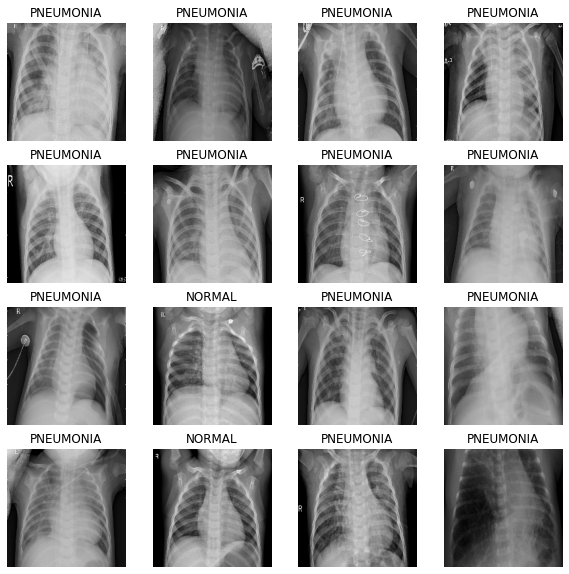

In [14]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

# train에 있는 batch 중 첫 번째 배치를 추출
image_batch, label_batch = next(iter(train_ds))

# 시각화 테스트
show_batch(image_batch.numpy(), label_batch.numpy())

---
## CNN 모델링
---
**Batch Normalization**과 **Dropout**이라는 두 가지 regularization 기법이 동시에 사용된다.

variance shift를 억제하는 Batch Normalization과  
이를 유발하는 Dropout을 동시에 사용하는 것이 어울리지 않아  
일반적으로 이런 방법은 잘 사용되지 않거나, 금기시된다.

### Convolution block

In [15]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])    
    return block

### Dense Block

In [16]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])    
    return block

### 모델 생성 함수

In [17]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

---
### 데이터 imbalance 처리
트레이닝 데이터에 폐렴 이미지가 더 많다  
한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있다  
이런 문제들을 해결하는 방법으로 **Weight balancing**이라는 테크닉이 사용  

#### Weight balancing
training set의 각 데이터에서 loss를 계산할 때 **특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법**  
Keras는 **model.fit()** 을 호출할 때 파라미터로 넘기는 **class_weight** 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원  



In [18]:
# weight를'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정

# Normal 이미지에 사용할 weight
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
# Pneumonia 이미지에 사용할 weight
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


---
### 모델 생성

In [19]:
with tf.device('/GPU:0'):
    model = build_model()

    # 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    # 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용
    # optimizer로 'adam'을 사용
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

### 모델 훈련

In [20]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 66s 202ms/step - loss: 0.3995 - accuracy: 0.8058 - precision: 0.9460 - recall: 0.7836 - val_loss: 0.6496 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 52s 200ms/step - loss: 0.2354 - accuracy: 0.9023 - precision: 0.9707 - recall: 0.8958 - val_loss: 1.3234 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 52s 201ms/step - loss: 0.2166 - accuracy: 0.9155 - precision: 0.9719 - recall: 0.9127 - val_loss: 0.1601 - val_accuracy: 0.9356 - val_precision: 0.9205 - val_recall: 0.9987
Epoch 4/10
261/261 [==============================] - 53s 204ms/step - loss: 0.1855 - accuracy: 0.9298 - precision: 0.9760 - recall: 0.9285 - val_loss: 0.0954 - val_accuracy: 0.9596 - val_precision: 0.9751 - val_recall: 0.9700
Epoch 5/10
261/261 [==============================] - 54s 209ms/step - loss: 0.1722 - accura

### 결과 확인
#### Epochs 별 모델의 precision, recall, accuracy, loss 변화 시각화

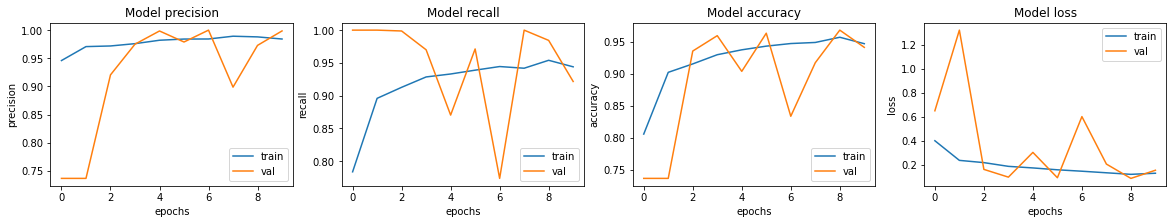

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

모델 평가를 위해 loss, accuracy, precision, recall 값을 출력

In [22]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 109ms/step - loss: 0.4430 - accuracy: 0.8574 - precision: 0.8413 - recall: 0.9513
Loss: 0.44296377897262573,
Accuracy: 0.8573718070983887,
Precision: 0.841269850730896,
Recall: 0.9512820243835449
